## Implementing strategy from "High-frequency trading in a limit order book" by Sasha Stoikov

https://www.math.nyu.edu/~avellane/HighFrequencyTrading.pdf

* Finding sigma from market data
* Testing fixed time horizon strategy
* Testing infinite time horizon strategy


In [2]:
from simulator import Sim
from strategy_stoikov_infinite import StoikovStrategy as StoikovStrategy_infinite
from strategy_stoikov import StoikovStrategy
from get_info import get_pnl
from load_data import load_md_from_file


import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

NROWS = 1_000_000

### 1. Loading Market Data

In [3]:
PATH_TO_FILE = 'md/btcusdt:Binance:LinearPerpetual/'


In [4]:
md = load_md_from_file(path=PATH_TO_FILE, nrows=NROWS)

### 2. Finding sigma

In [114]:
mdata = pd.read_csv('md/btcusdt:Binance:LinearPerpetual/lobs.csv')
mdata['receive_ts'] = pd.to_datetime(mdata['receive_ts'])

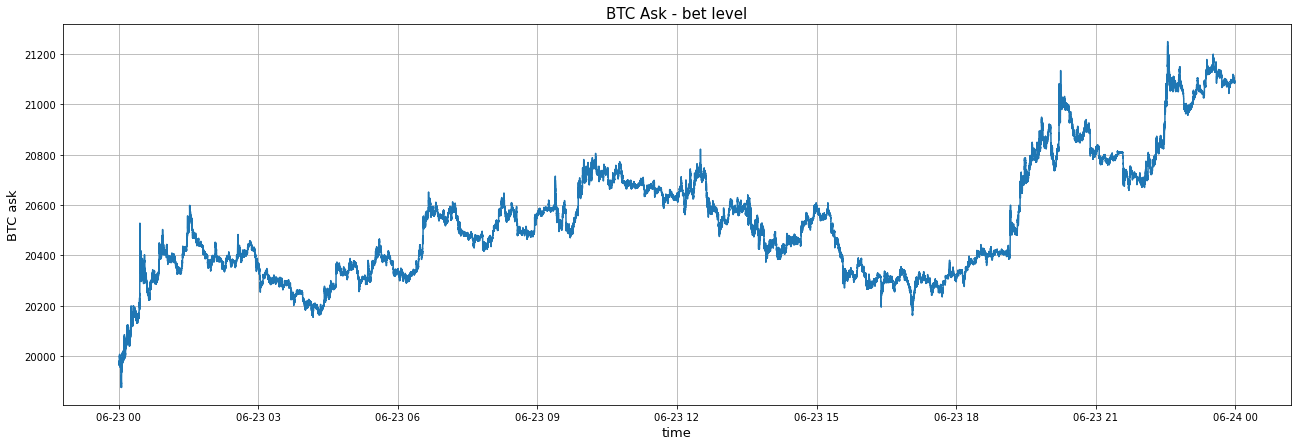

In [115]:
plt.figure(figsize=(22, 7))

plt.plot(mdata['receive_ts'], mdata['btcusdt:Binance:LinearPerpetual_ask_price_0'], '-')
plt.xlabel("time", fontsize=13)
plt.ylabel("BTC ask", fontsize=13)
plt.title("BTC Ask - bet level", fontsize=15)
plt.grid()

In [116]:
mdata = pd.read_csv('md/btcusdt:Binance:LinearPerpetual/lobs.csv')
mdata['receive_ts'] = pd.to_datetime(mdata['receive_ts'])
mdata['btcusdt:Binance:LinearPerpetual_ask_price_0'].describe()

count    2.541356e+06
mean     2.053025e+04
std      2.323556e+02
min      1.987500e+04
25%      2.034250e+04
50%      2.048960e+04
75%      2.068010e+04
max      2.125000e+04
Name: btcusdt:Binance:LinearPerpetual_ask_price_0, dtype: float64

In [117]:
mdata['log_returns'] = np.log(mdata['btcusdt:Binance:LinearPerpetual_ask_price_0']/mdata['btcusdt:Binance:LinearPerpetual_ask_price_0'].shift())

In [118]:
mdata['log_returns'].std()*365**.5 * 100

0.05170208389966626

**Daily volatility - 5%**

### 3. Strategy with time horizon

In [37]:
def plot_results(gamma, sigma, kappa):
    latency = pd.Timedelta(10, 'ms').delta
    md_latency = pd.Timedelta(10, 'ms').delta

    sim = Sim(md, latency, md_latency)
    
    delay = pd.Timedelta(0.1, 's').delta
    hold_time = pd.Timedelta(10, 's').delta
    strategy = StoikovStrategy(delay, gamma = gamma, sigma = sigma, kappa = kappa, hold_time = hold_time)
    
    trades_list, md_list, updates_list, all_orders = strategy.run(sim)
    df = get_pnl(updates_list)
    
    df['T-t'] = (df['receive_ts'] - df['receive_ts'][0]) / (df.iloc[-1]['receive_ts'] - df['receive_ts'][0])
    df['reserve_price'] = df['mid_price'] - df['BTC'] * gamma * sigma * sigma * df['T-t']
    df['spread'] = gamma * sigma**2 * df['T-t'] + 2/gamma * np.log(1 + gamma/kappa)

    plt.figure(figsize=(22, 25))
    dt = pd.to_datetime(df.receive_ts)

    plt.subplot(5, 1, 1)
    plt.plot(dt, df.reserve_price, '-')
    plt.plot(dt, df.mid_price, '-')
    plt.xlabel("time", fontsize=13)
    plt.ylabel("BTC price", fontsize=13)
    plt.title("BTC price", fontsize=15)
    plt.grid()

    plt.subplot(5, 1, 2)
    plt.plot(dt, df.spread, '-')
    plt.xlabel("time", fontsize=13)
    plt.ylabel("spread", fontsize=13)
    plt.title("spread", fontsize=15)
    plt.grid()

    plt.subplot(5, 1, 3)
    plt.plot(dt, df.reserve_price - df.mid_price, '-')
    plt.xlabel("time", fontsize=13)
    plt.ylabel("reserve_price-mid_price", fontsize=13)
    plt.title("reserve price - mid price", fontsize=15)
    plt.grid()

    ax1 = plt.subplot(5, 1, 4)
    ax2 = ax1.twinx()
    ax1.plot(dt, df.BTC, '-', label='BTC reserves')
    ax2.plot(dt, df.USD, '-', color='g', label='USD reserves')
    ax1.set_xlabel("time", fontsize=13)
    ax1.set_ylabel("BTC position", fontsize=13)
    ax2.set_ylabel("USD position", fontsize=13)
    ax1.legend()
    ax2.legend()
    plt.title("Inventory for gamma = %.1f, sigma = %.1f, k = %.1f"%(gamma, sigma, kappa), fontsize=15)
    plt.grid()

    plt.subplot(5, 1, 5)
    plt.plot(dt, df.total, '-')
    plt.xlabel("time", fontsize=13)
    plt.ylabel("PnL", fontsize=13)
    plt.title("PnL for gamma = %.1f, sigma = %.1f, k = %.1f"%(gamma, sigma, kappa), fontsize=15)
    plt.grid()

    plt.tight_layout()
    plt.show()

* Gamma = 0.1
* Sigma = 5
* kappa = 1.5

In [38]:
gamma = 0.1
sigma = 5
kappa = 1.5

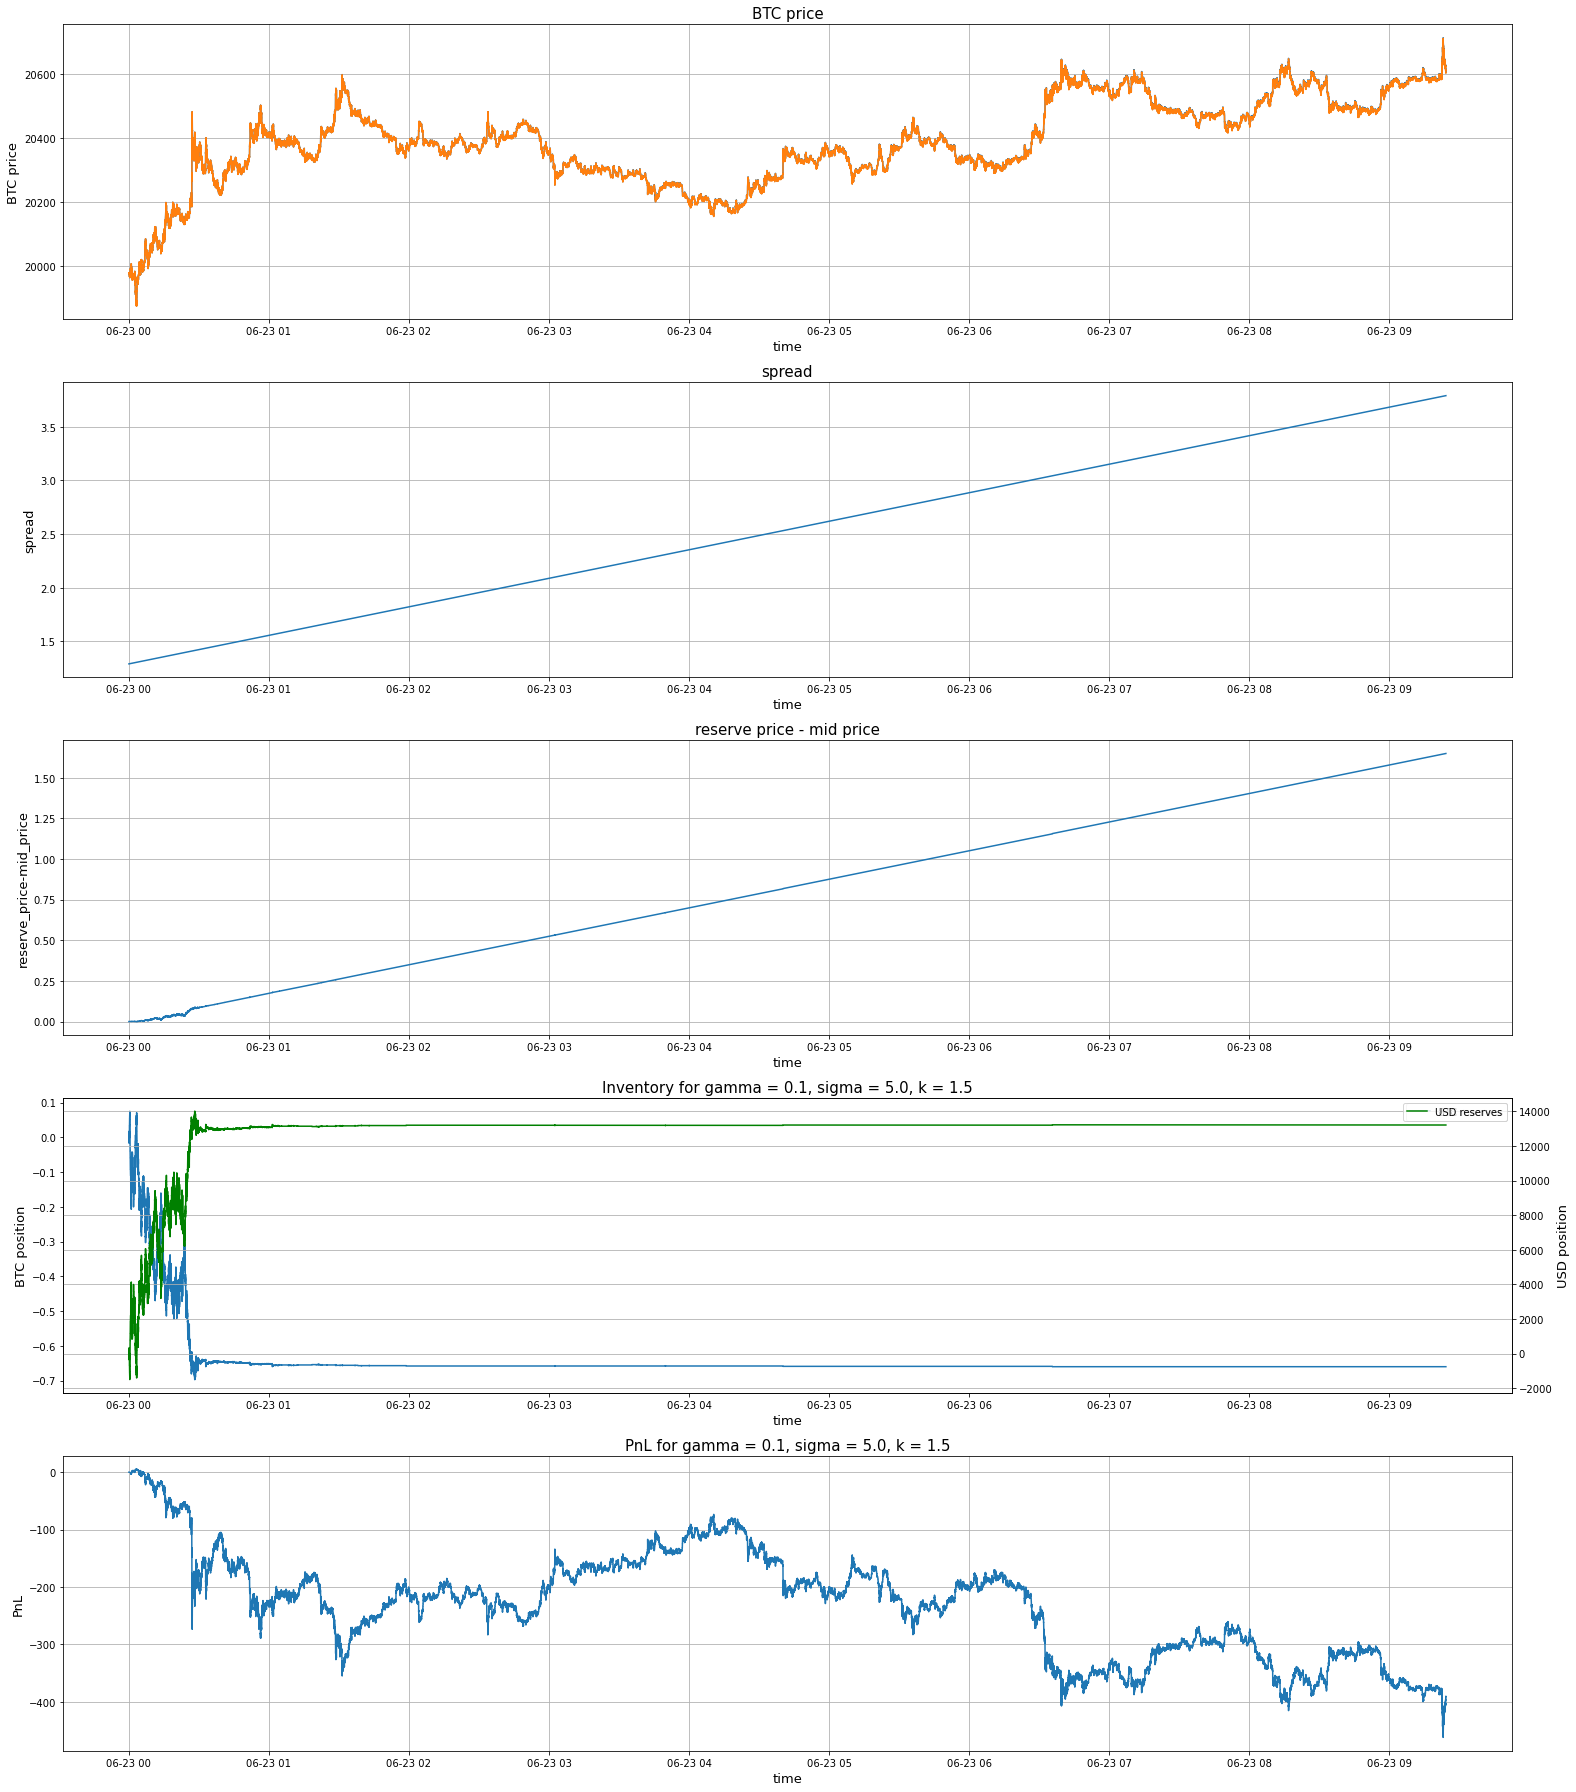

In [39]:
plot_results(gamma, sigma, kappa)

* Gamma = 1
* Sigma = 7
* kappa = 1.5

In [17]:
gamma = 1
sigma = 7
kappa = 1.5

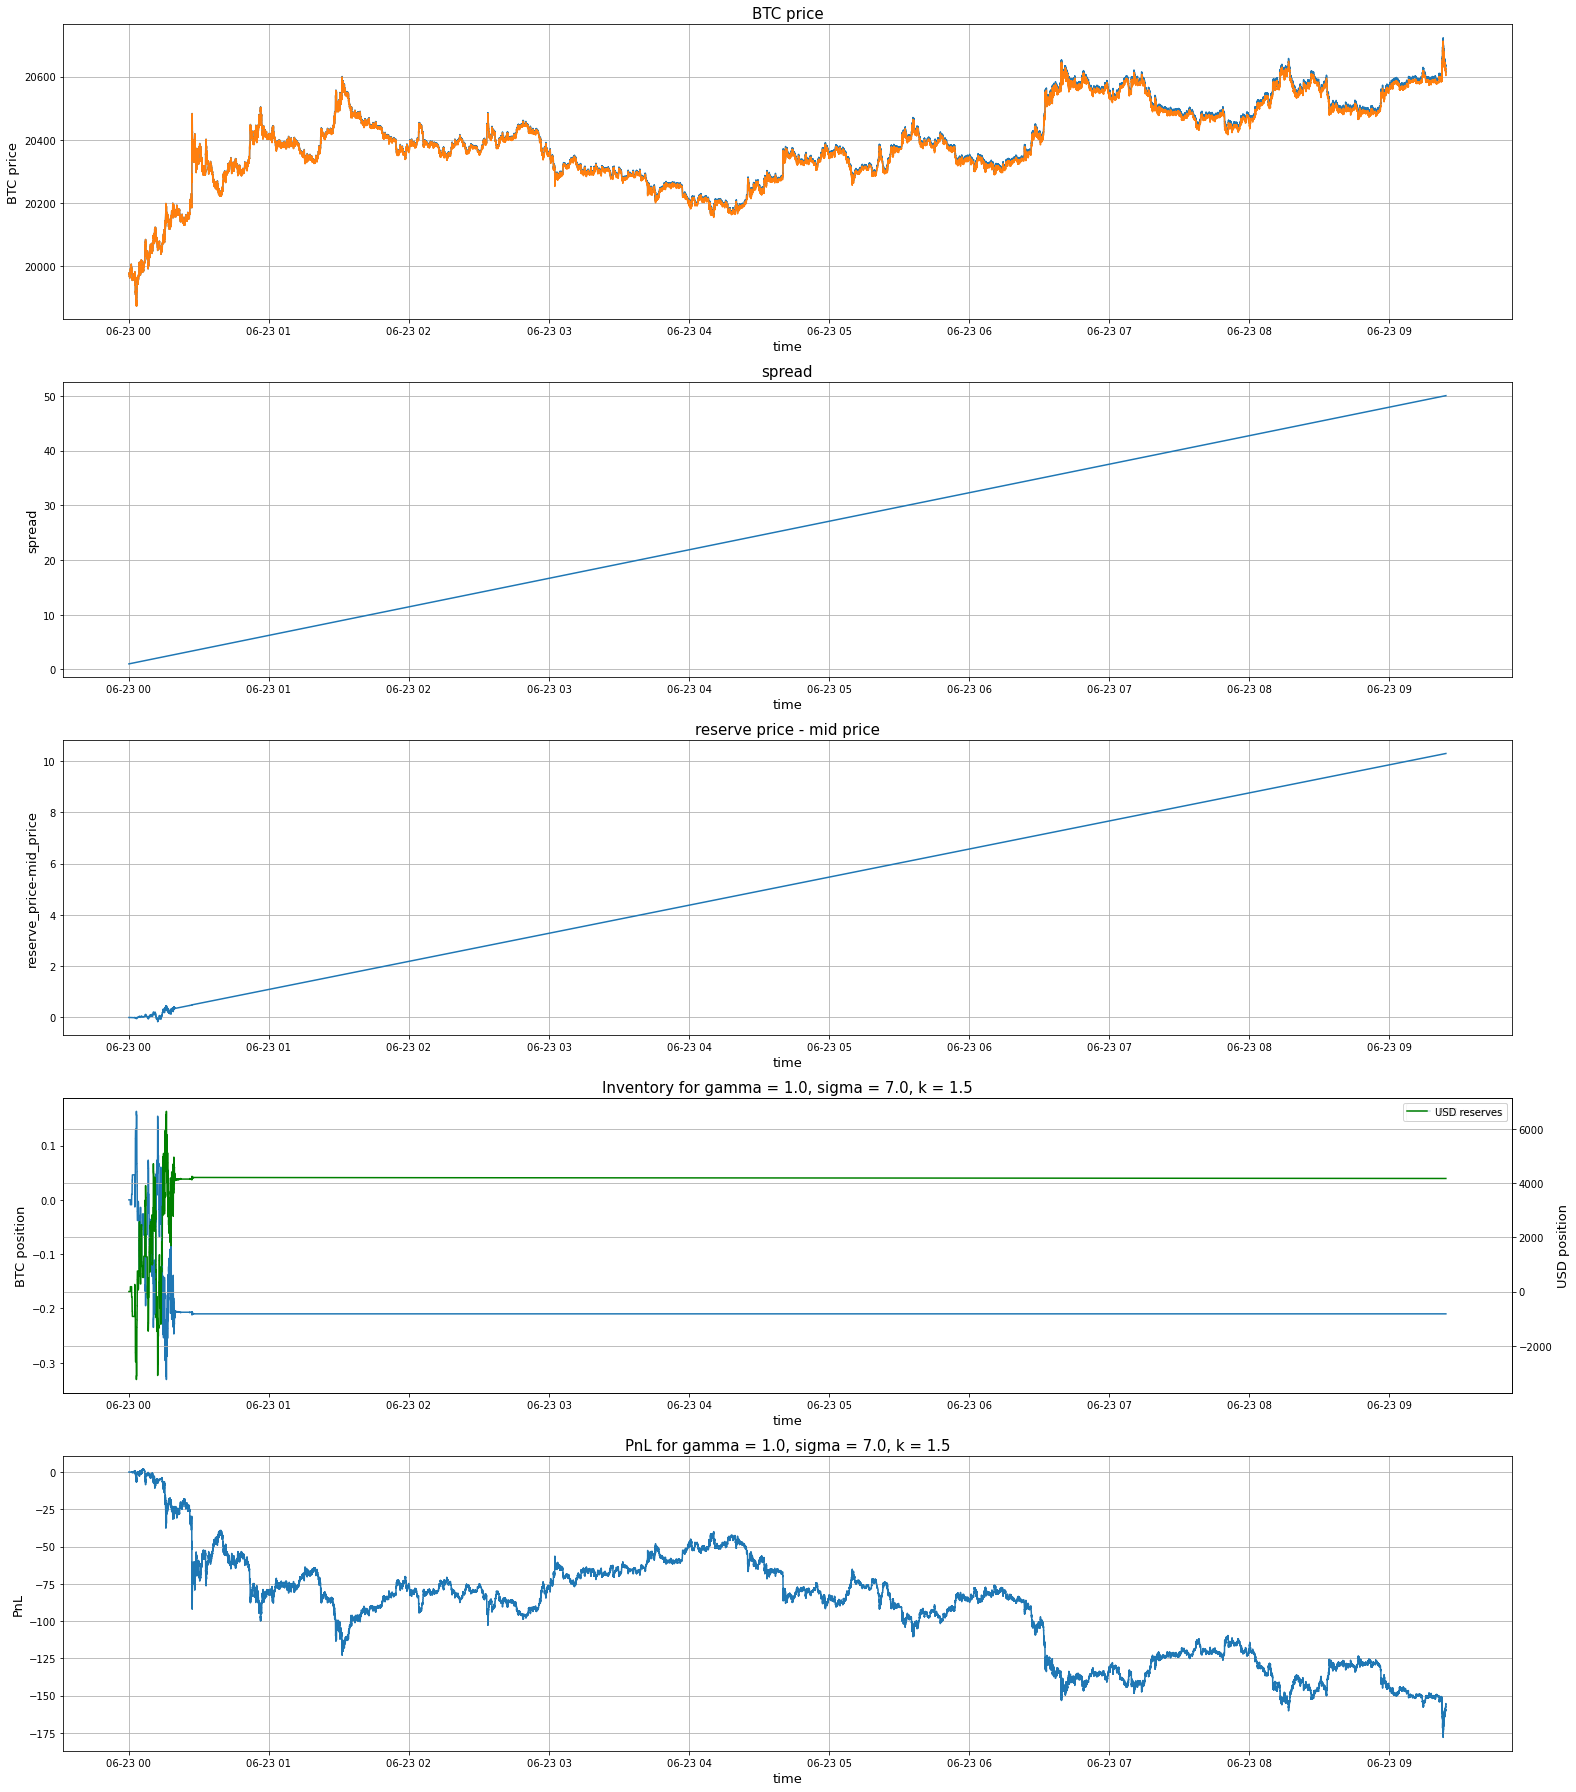

In [41]:
plot_results(gamma, sigma, kappa)

* Gamma = 0.01
* Sigma = 2
* kappa = 1.5

In [42]:
gamma = 0.01
sigma = 2
kappa = 1.5

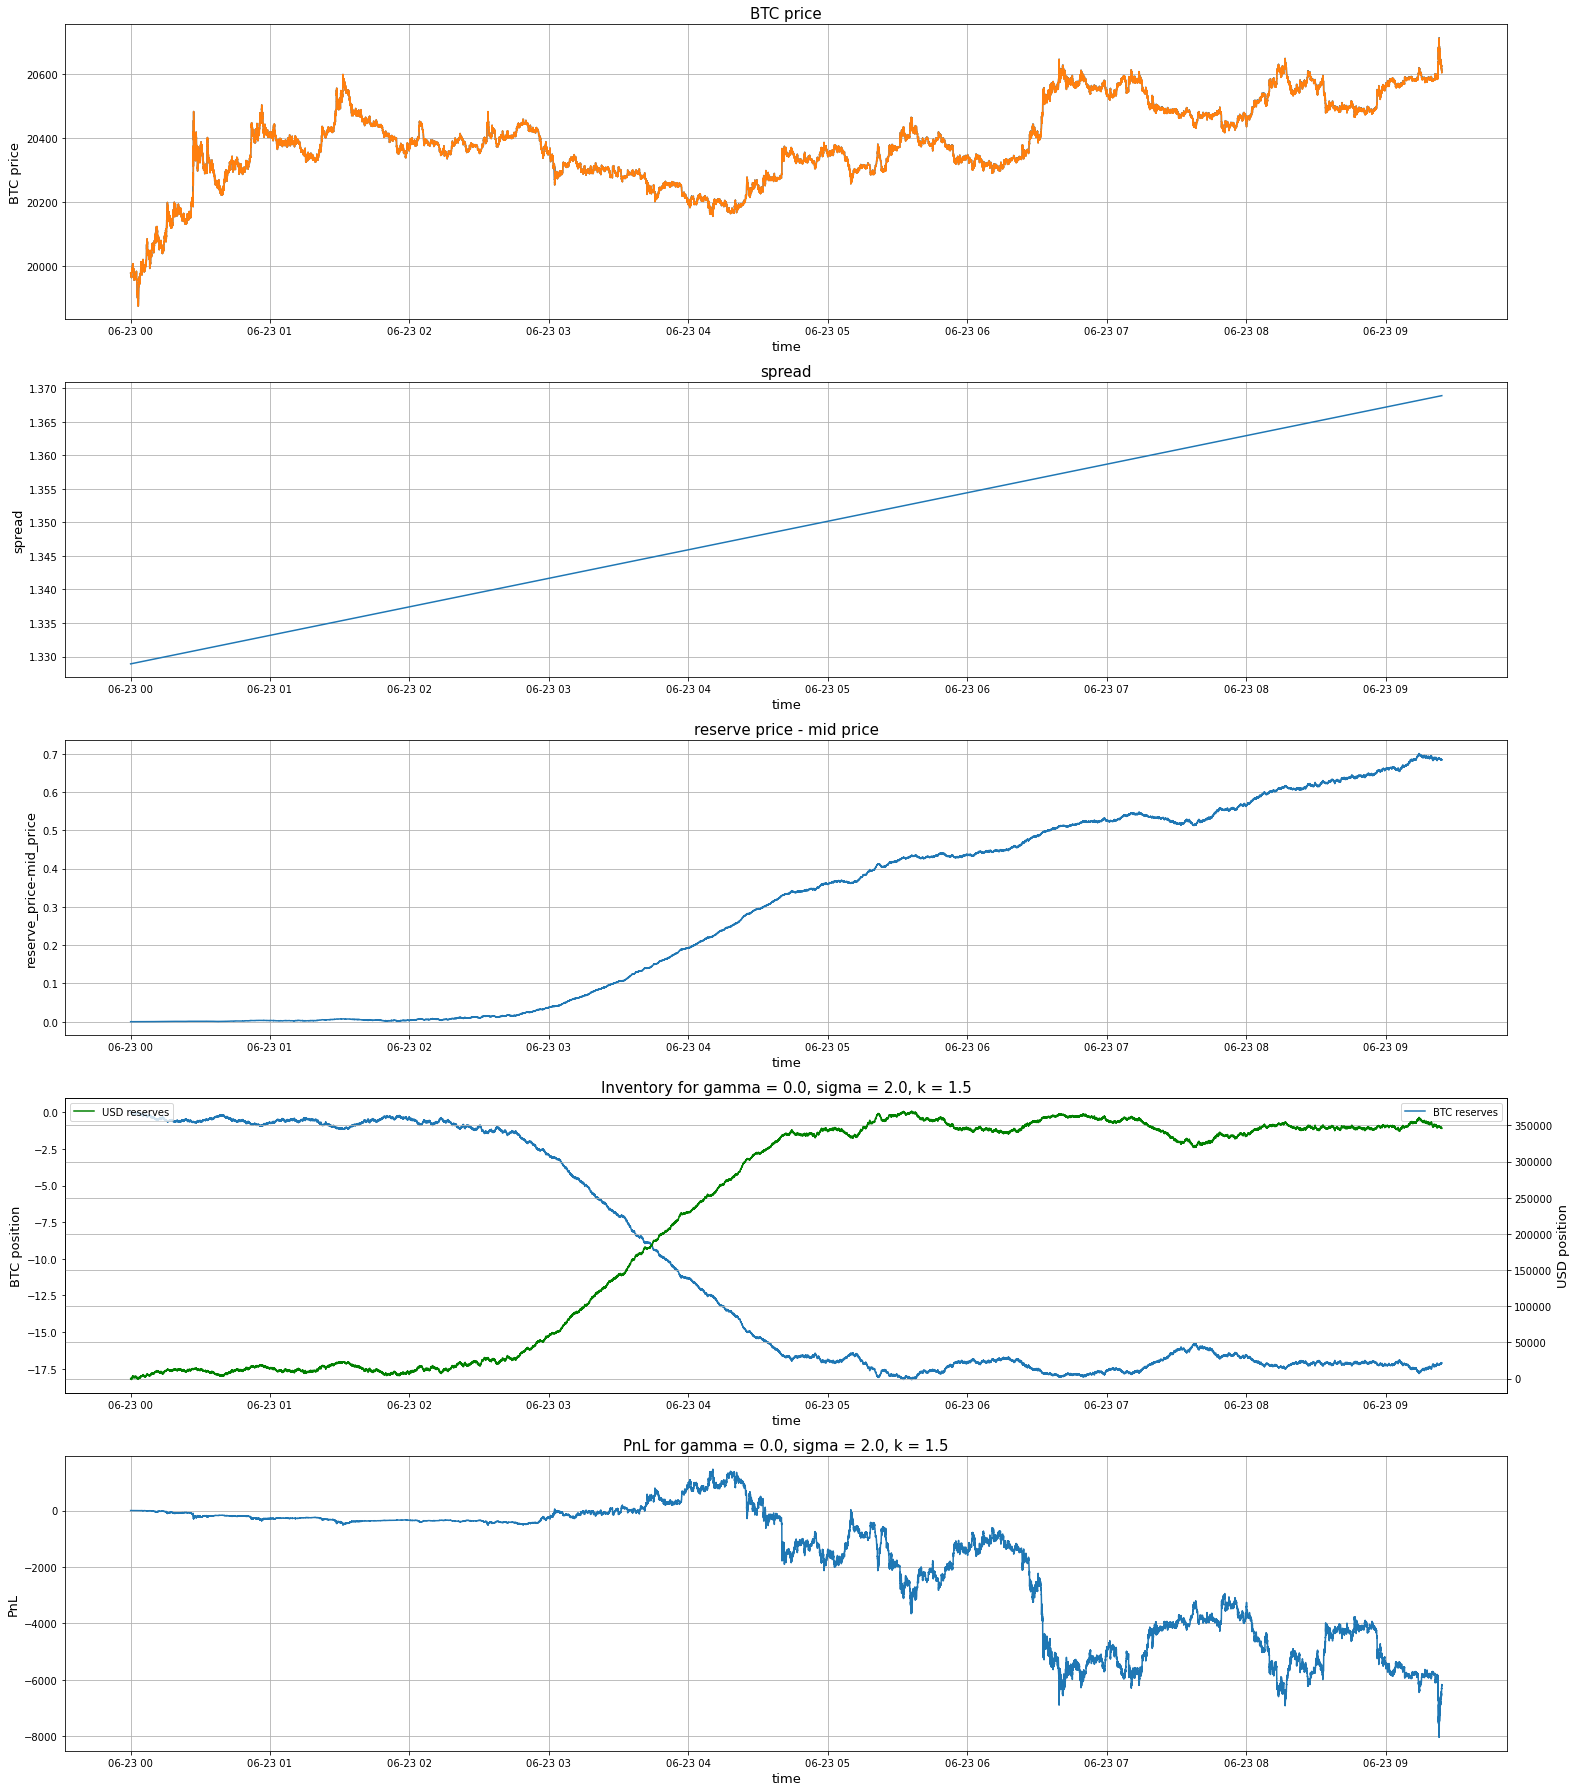

In [43]:
plot_results(gamma, sigma, kappa)

After some time we have problem - we have plato after some time in terms of reserves, as we start increase our spread. Obviusly as our spread is linear by time

In this paper - https://arxiv.org/pdf/1105.3115.pdf - they find that only for T-t close to 1 it starts to affest spread, so they suggest optimal bid

## 4. Strategy infinite time horizon

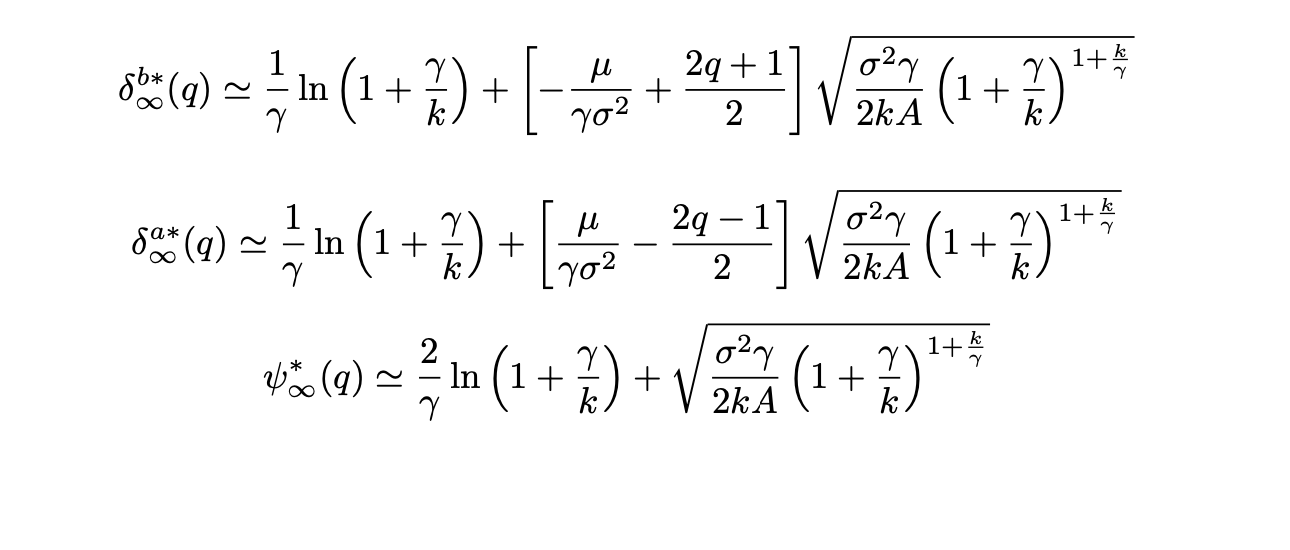

In [14]:
from IPython.display import Image
Image(filename='Screenshot 2022-11-05 at 01.41.09.png') 

In [9]:
def plot_results_inf(gamma, sigma, kappa, A):
    latency = pd.Timedelta(10, 'ms').delta
    md_latency = pd.Timedelta(10, 'ms').delta
    sim = Sim(md, latency, md_latency)

    delay = pd.Timedelta(0.1, 's').delta
    hold_time = pd.Timedelta(10, 's').delta
    # using infinte time horizon
    strategy = StoikovStrategy_infinite(delay, gamma = gamma, sigma = sigma, kappa = kappa, A = A, hold_time = hold_time)

    trades_list, md_list, updates_list, all_orders = strategy.run(sim)
    df = get_pnl(updates_list)
    
    df['ask_price'] = df['mid_price'] + 1/gamma * np.log(1 + gamma / kappa) - (df['BTC'] - 1/2) * (sigma**2 * gamma / (2 * kappa * A) * (1 + gamma/kappa)**(1 + kappa/gamma))**.5
    df['bid_price'] = df['mid_price'] - (1/gamma * np.log(1 + gamma / kappa) + (df['BTC'] + 1/2) * (sigma**2 * gamma / (2 * kappa * A) * (1 + gamma/kappa)**(1 + kappa/gamma))**.5)

    df['reserve_price'] = (df['ask_price'] + df['bid_price']) / 2
    df['spread'] = 2/gamma * np.log(1 + (gamma/kappa)) + ((sigma**2 * gamma) / (2 * kappa * A) * (1 + gamma / kappa)**(1 + kappa / gamma))**.5

    plt.figure(figsize=(22, 25))
    dt = pd.to_datetime(df.receive_ts)

    plt.subplot(5, 1, 1)
    plt.plot(dt, df.reserve_price, '-')
    plt.plot(dt, df.mid_price, '-')
    plt.xlabel("time", fontsize=13)
    plt.ylabel("BTC price", fontsize=13)
    plt.title("BTC price", fontsize=15)
    plt.grid()

    plt.subplot(5, 1, 2)
    plt.plot(dt, df.spread, '-')
    plt.xlabel("time", fontsize=13)
    plt.ylabel("spread", fontsize=13)
    plt.title("spread", fontsize=15)
    plt.grid()

    plt.subplot(5, 1, 3)
    plt.plot(dt, df.reserve_price - df.mid_price, '-')
    plt.xlabel("time", fontsize=13)
    plt.ylabel("reserve_price-mid_price", fontsize=13)
    plt.title("reserve price - mid price", fontsize=15)
    plt.grid()

    ax1 = plt.subplot(5, 1, 4)
    ax2 = ax1.twinx()
    ax1.plot(dt, df.BTC, '-', label='BTC reserves')
    ax2.plot(dt, df.USD, '-', color='g', label='USD reserves')
    ax1.set_xlabel("time", fontsize=13)
    ax1.set_ylabel("BTC position", fontsize=13)
    ax2.set_ylabel("USD position", fontsize=13)
    ax1.legend()
    ax2.legend()
    plt.title("Inventory for gamma = %.1f, sigma = %.1f, k = %.1f"%(gamma, sigma, kappa), fontsize=15)
    plt.grid()

    plt.subplot(5, 1, 5)
    plt.plot(dt, df.total, '-')
    plt.xlabel("time", fontsize=13)
    plt.ylabel("PnL", fontsize=13)
    plt.title("PnL for gamma = %.1f, sigma = %.1f, k = %.1f"%(gamma, sigma, kappa), fontsize=15)
    plt.grid()

    plt.tight_layout()
    plt.show()

In [10]:
gamma = 0.01
sigma = 2
kappa = 1.5
A = .9

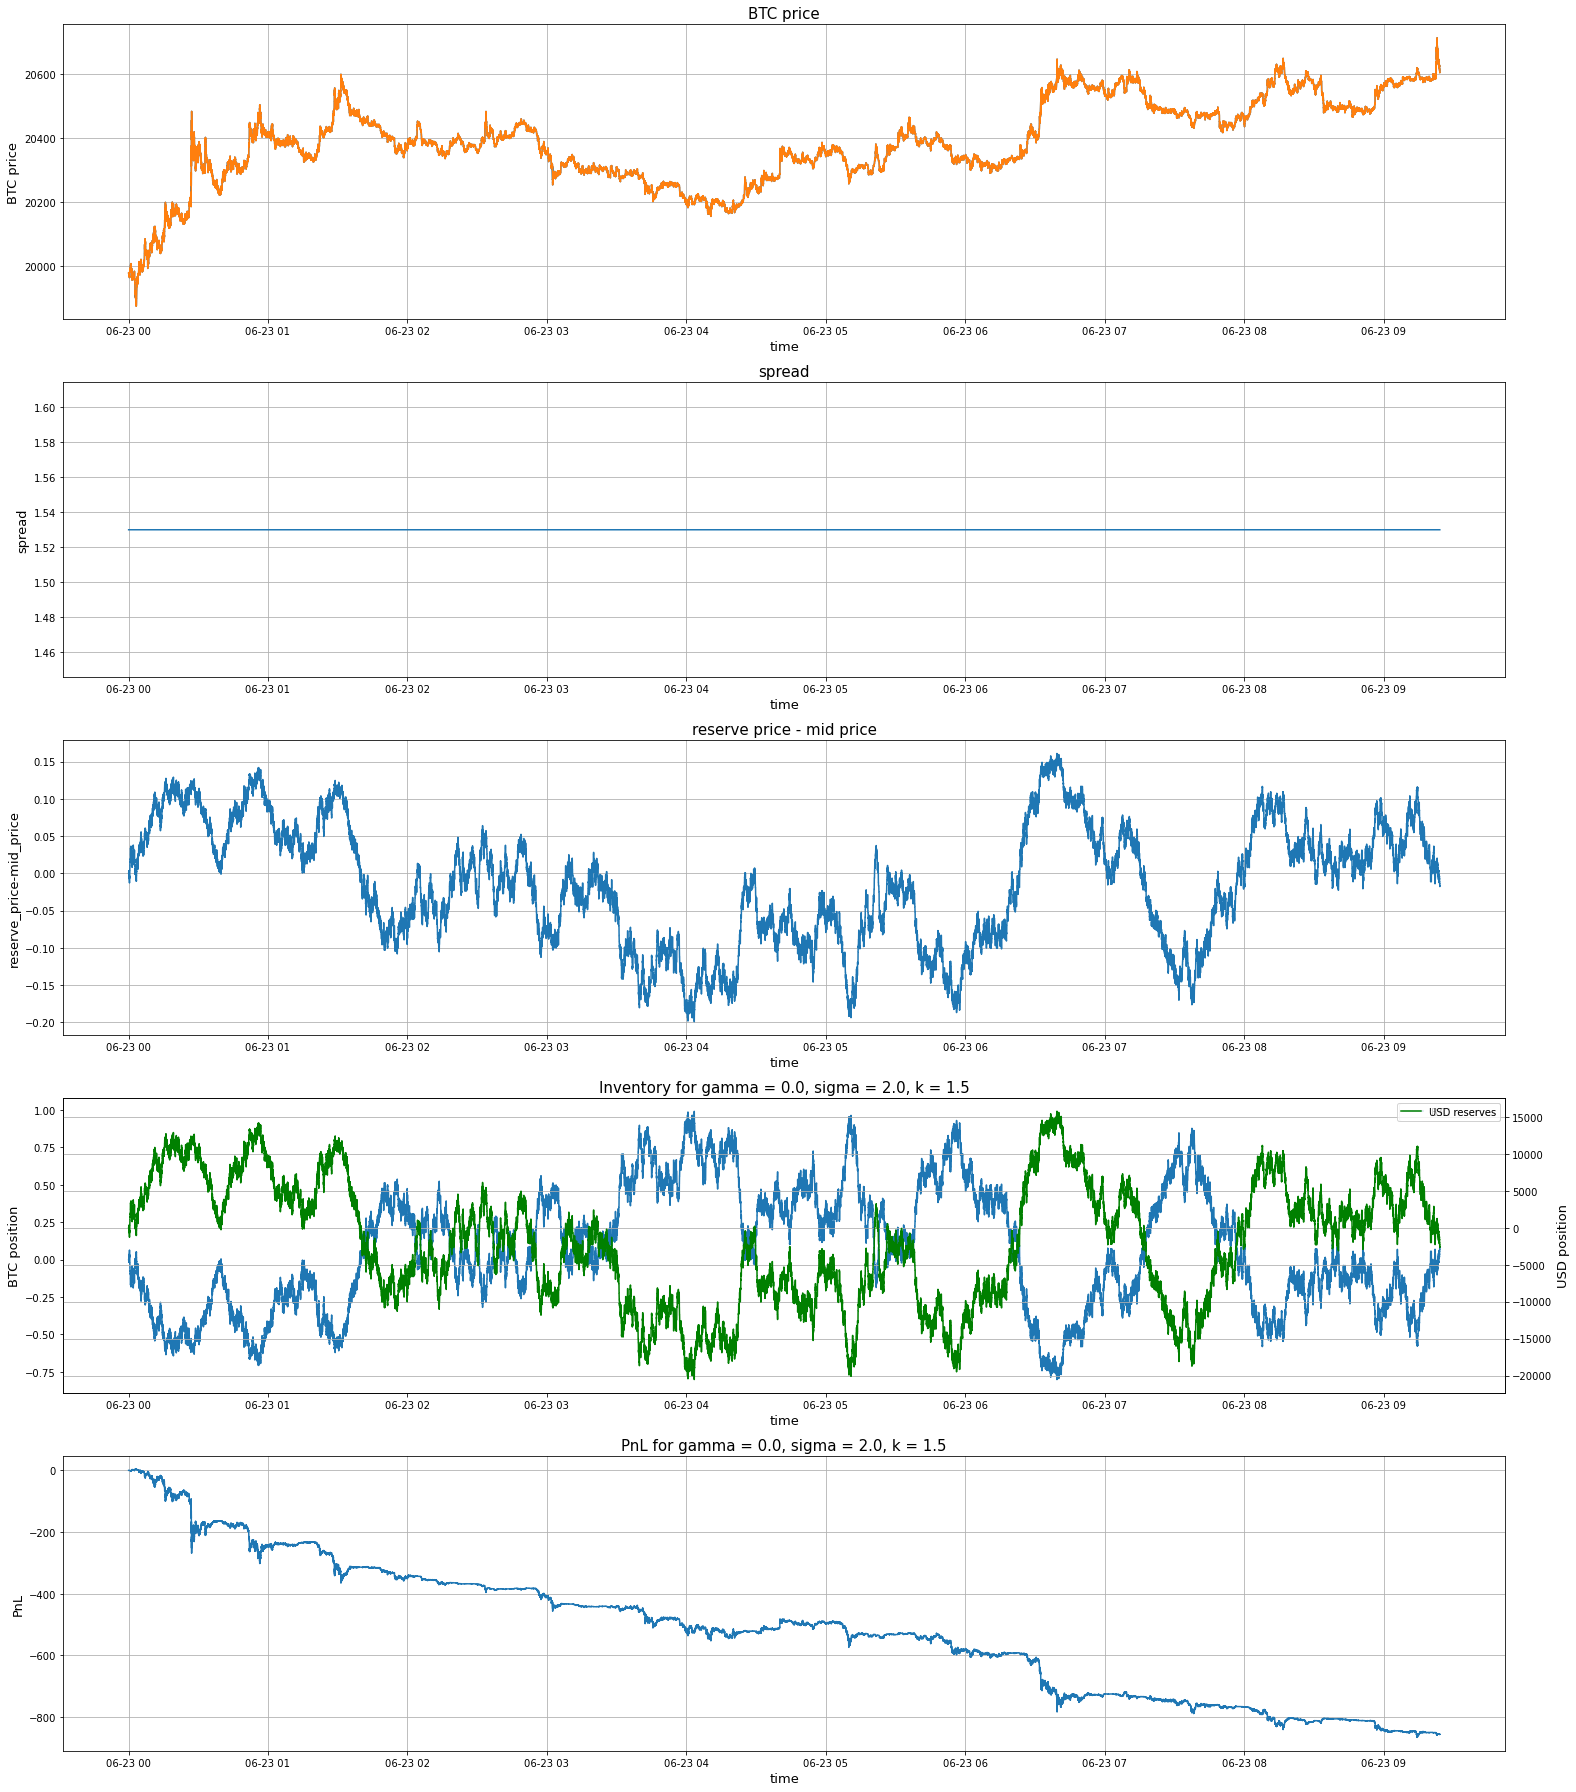

In [11]:
plot_results_inf(gamma, sigma, kappa, A)

In [12]:
gamma = 0.1
sigma = 7
kappa = .3
A = .9

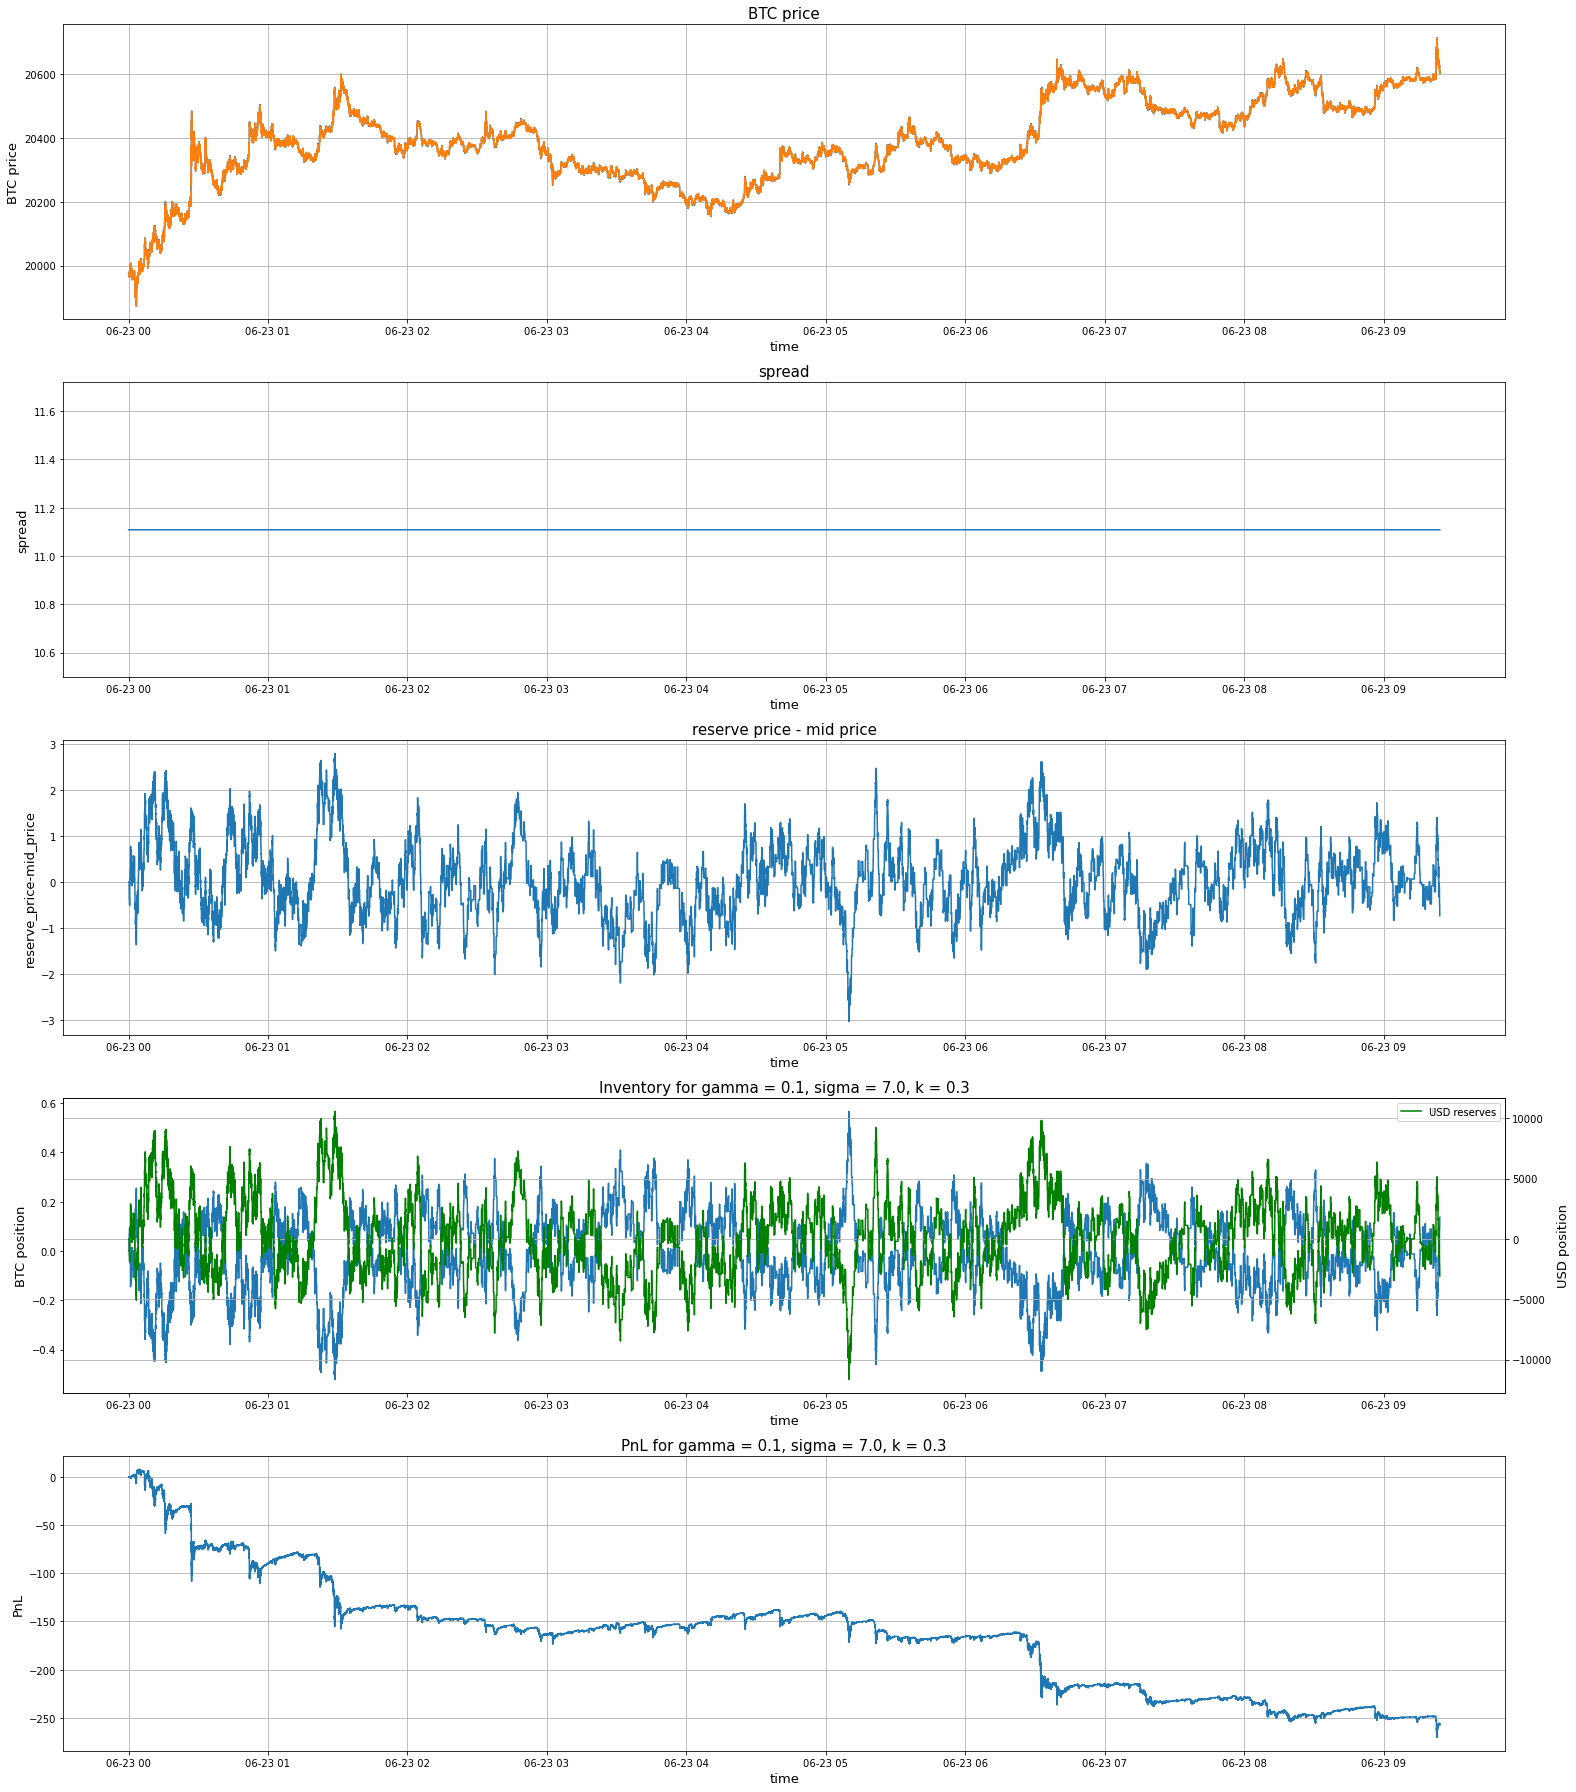

In [13]:
plot_results_inf(gamma, sigma, kappa, A)

In [14]:
gamma = 1
sigma = 2
kappa = .3
A = .9

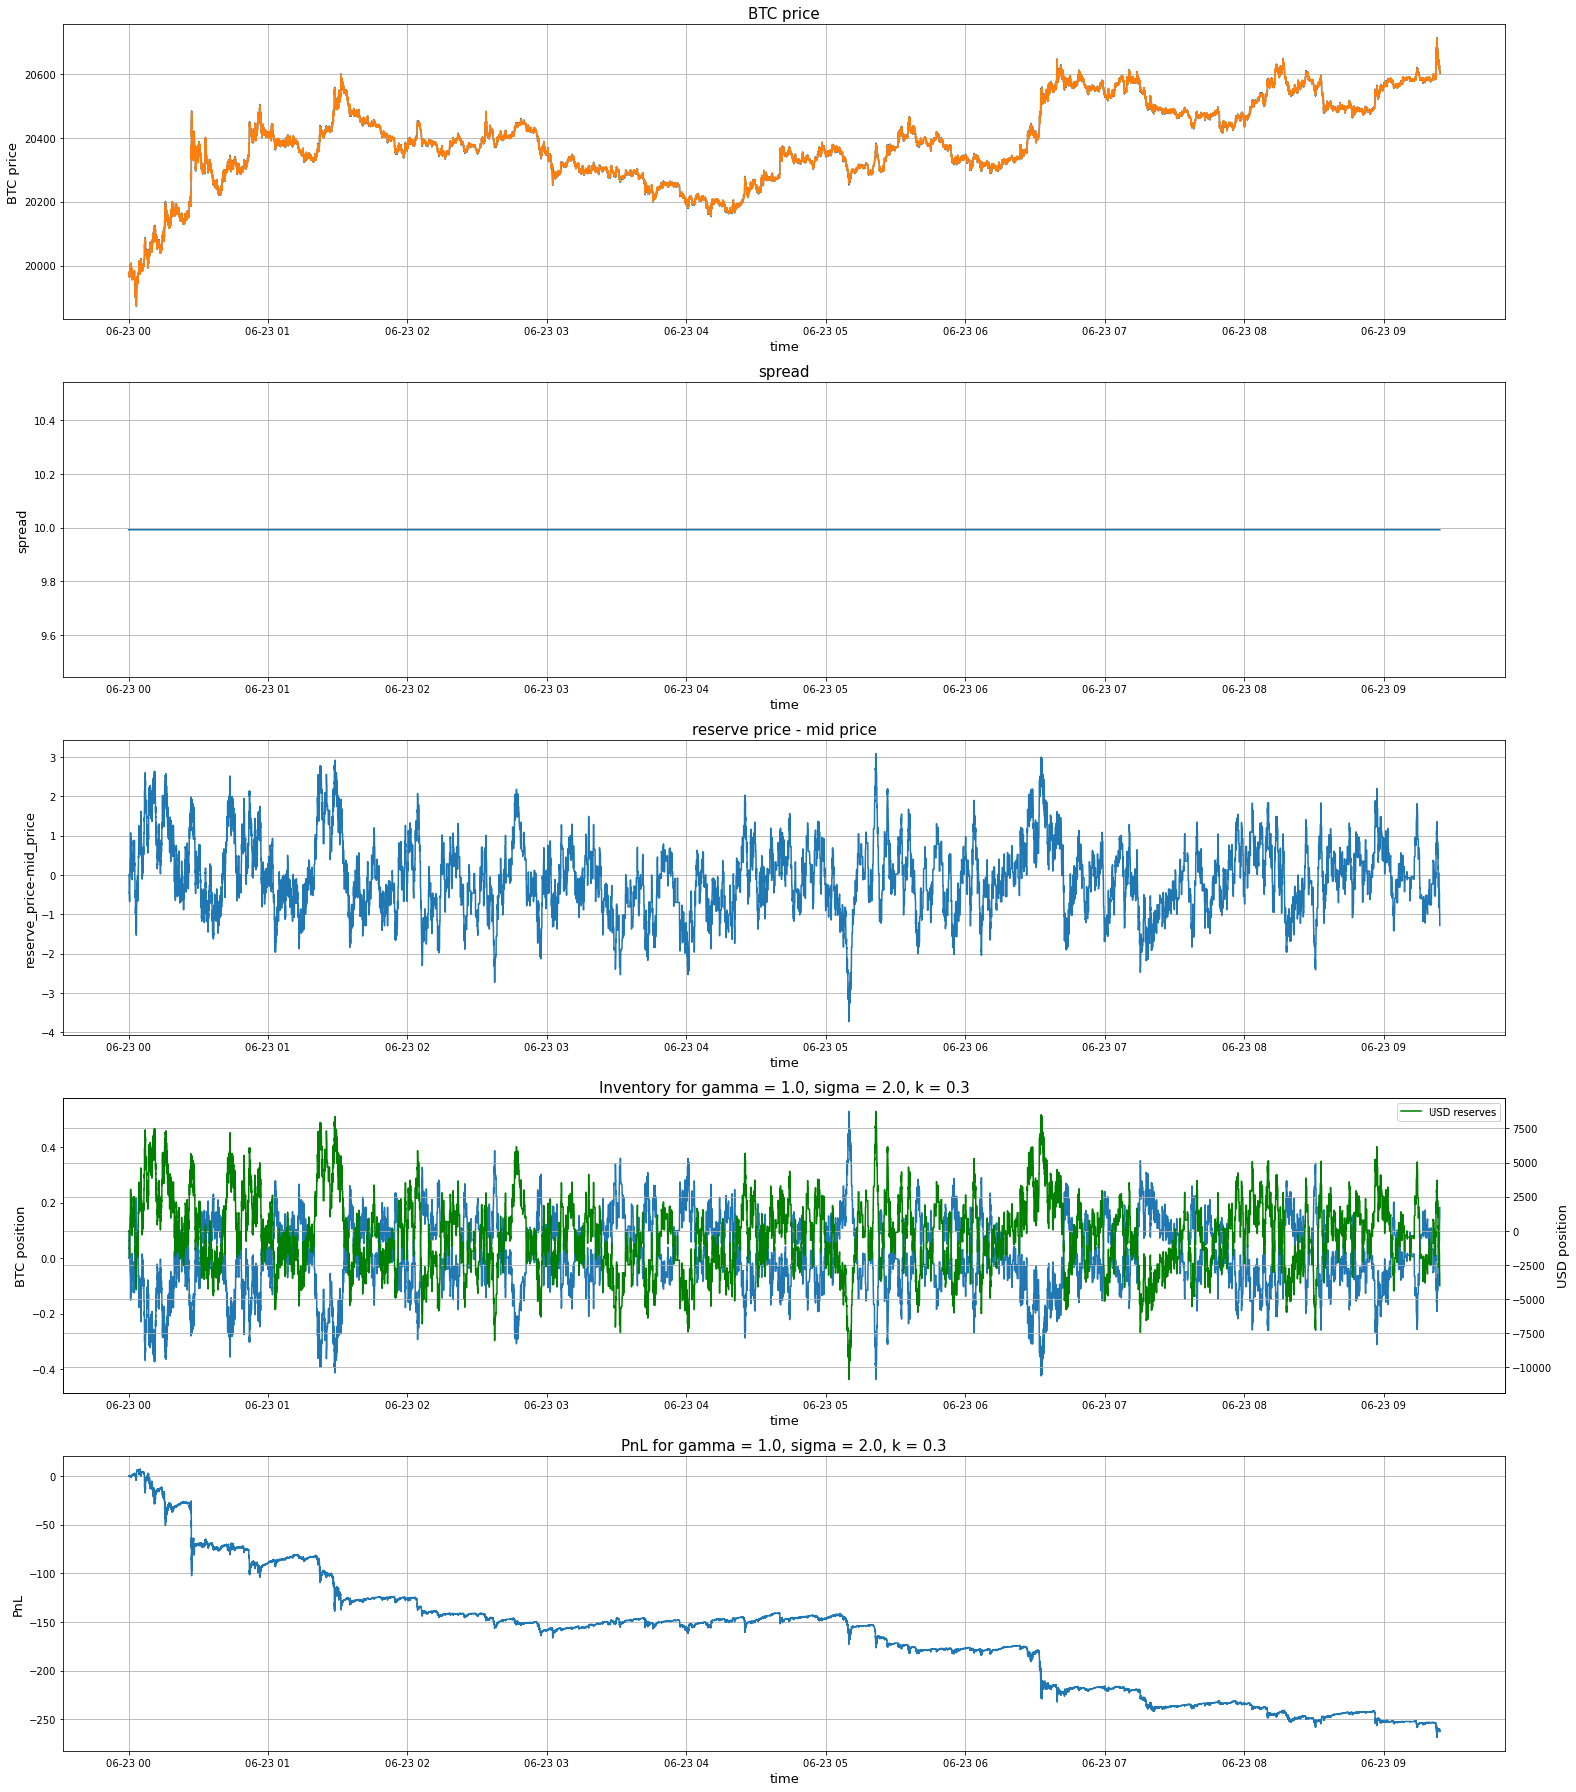

In [15]:
plot_results_inf(gamma, sigma, kappa, A)

* Now we don't have problem of increasing spread - obviously our spread will be dynamic when we add dynamic volatility 

PnL is not good still